# Reading In Data

In [89]:
%matplotlib inline

In [124]:
import pandas as pd
import matplotlib.pyplot as plt

#Read in data
Feb_hrl_lmps = pd.read_csv('Feb_hrl_lmps.csv')
Feb_auction = pd.read_csv('Feb_auction.csv')

#Convert column to datetimes
Feb_hrl_lmps['datetime_beginning_ept'] = pd.to_datetime(Feb_hrl_lmps['datetime_beginning_ept'])

#Convert to matrix format
Feb_hrl_lmps = Feb_hrl_lmps.pivot(index = 'datetime_beginning_ept', columns = 'pnode_id', values = 'congestion_price_da')

In [125]:
Feb_hrl_lmps.sample(3)

pnode_id,1,3,48592,48593,48594,48595,48596,48603,48604,48605,...,2156112519,2156112520,2156112521,2156112523,2156112524,2156112525,2156112528,2156112529,2156112530,2156112531
datetime_beginning_ept,,,,,,,,,,,,,,,,,,,,,
2022-02-06 04:00:00,4.027803,14.601313,2.43,2.43,4.08,4.08,4.08,4.37,4.37,3.19,...,-30.69,-15.75,-26.63,2.45,-21.94,7.95,17.72,1.80,40.98,2.16
2022-02-11 04:00:00,-0.454893,2.381027,-0.22,-0.22,-0.15,-0.15,-0.15,-0.17,-0.17,-0.37,...,-24.06,-1.89,-18.19,-0.21,-6.35,8.33,1.07,4.64,-1.05,-0.02
2022-02-04 14:00:00,1.002407,0.235184,-1.51,-1.51,-0.19,-0.19,-0.19,-2.55,-2.55,-1.16,...,0.32,0.35,0.35,-1.62,1.55,0.30,-0.65,0.25,-0.83,-1.07


In [126]:
Feb_auction.sample(3)

,FTRID,Class Type,Participant,Source Node,Source PNODEID,Sink Node,Sink PNODEID,Trade Type,Cleared MW,Obligation MCP
62502,257380299,OffPeak,APOETR,20 BRAID24 KV BR-2,32417601,946 UNIV13.5 KV UP33-1,32417759,Sell,0.2,79.41
89401,256807079,OffPeak,MSCFTR,TARENTUM - AP,24668858,PENELEC,51300,Buy,0.1,583.66
126903,259250862,OnPeak,GRGE,HOLLYMD 35 KV TX1,34886791,MTEAGLE 35 KV TX1,34886823,Buy,2.0,-511.33


## Getting Average Congestion LMP for relevant hours

In [127]:
import numpy as np

def lookup_lmp(df, lmps):
    
    class_type = df.index[0]
    
    if class_type == 'OnPeak':
        f = ((lmps.index.weekday <= 5) &\
            (lmps.index.hour >= 7) &\
            (lmps.index.hour < 23))
    elif class_type == 'OffPeak':
        f = ~((lmps.index.weekday <= 5) &\
            (lmps.index.hour >= 7) &\
            (lmps.index.hour < 23))
    else:
        f = lmps.index.weekday <= 7 #All days of week
        
    avg_lmp = lmps[f].sum().rename('congestion_price_da')
    
    df = df.merge(avg_lmp, left_on = 'Source PNODEID', right_index = True)
    df = df.rename(columns = {'congestion_price_da':'Source clmp'})
    
    df = df.merge(avg_lmp, left_on = 'Sink PNODEID', right_index = True)
    df = df.rename(columns = {'congestion_price_da':'Sink clmp'})
    
    return df

auc_results = Feb_auction.groupby('Class Type').apply(lookup_lmp, Feb_hrl_lmps)
auc_results.reset_index(drop=True, inplace = True)

In [128]:
auc_results.sample(3)

,FTRID,Class Type,Participant,Source Node,Source PNODEID,Sink Node,Sink PNODEID,Trade Type,Cleared MW,Obligation MCP,Source clmp,Sink clmp
124111,257818189,OnPeak,SEEAST,LINWDPE 18 KV CT1,21601794,EDDYSTON13 KV UNIT10,50525,Buy,3.0,-76.01,-2100.84,-2479.720000
83674,257910730,OnPeak,JANESE,1 LASALL24 KV LA-1,32417525,N ILLINOIS HUB,33092315,Sell,3.5,69.04,-4121.73,-4007.315055
94642,255163012,OnPeak,SEEAST,BLUEJACK69 KV DTEBELLF,74008739,TRENT 138 KV TRENTBS,1183232638,Buy,1.3,-110.88,382.30,300.390000


# Analyzing the Premia for Each FTR

In [129]:
#Compute the Premium for each FTR
auc_results['Payoff'] = auc_results['Sink clmp'] - auc_results['Source clmp']
auc_results['Premium'] = auc_results['Payoff'] - auc_results['Obligation MCP']

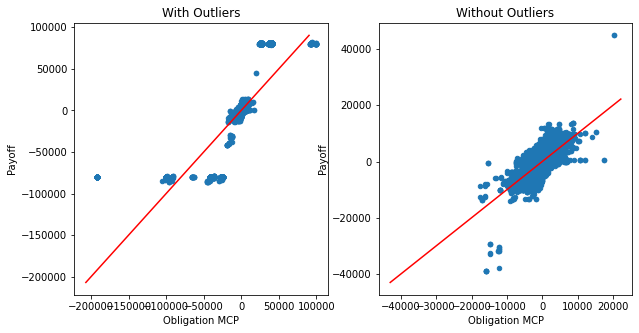

In [130]:
def plot_xy(ax, color='red'):
    l = min(ax.get_xlim()[0], ax.get_ylim()[0])
    r = min(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot([l, r], [l, r], color = color)
    
    
fig, ax = plt.subplots(1,2, figsize=(10,5))

buy_trades = auc_results['Trade Type'] == 'Buy'
outliers = (auc_results['Payoff'] > 50000) | (auc_results['Payoff'] < -40000)
auc_results.plot.scatter('Obligation MCP', 'Payoff',ax=ax[0])
ax[0].set_title('With Outliers')
plot_xy(ax[0])

auc_results[~outliers].plot.scatter('Obligation MCP', 'Payoff',ax=ax[1])
c=50000
ax[1].set_title('Without Outliers')
plot_xy(ax[1])

Text(0.5, 1.0, 'Sell Trades, No Outliers: Mean -158.98, Std 5134.45')

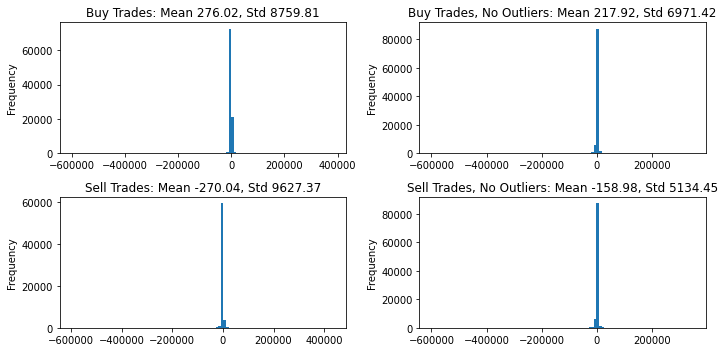

In [132]:
import numpy as np

def bool_to_pm1(xbool_):
    xpm1 = np.ones(xbool_.shape[0])
    xpm1[~xbool_] = -1
    return xpm1

auc_results['Premium'] = auc_results['Cleared MW']*(auc_results['Payoff'] - auc_results['Obligation MCP'])*bool_to_pm1(buy_trades)

fig, ax = plt.subplots(2,2, figsize = (10,5), tight_layout = True)

auc_results[buy_trades]['Premium'].plot.hist(bins = 100, ax = ax[0,0])
ax[0,0].set_title('Buy Trades: Mean {:.2f}, Std {:.2f}'.format(auc_results[buy_trades]['Premium'].mean(), auc_results[buy_trades]['Premium'].std()))

auc_results[buy_trades & ~outliers]['Premium'].plot.hist(bins = 100, ax = ax[0,1])
ax[0,1].set_title('Buy Trades, No Outliers: Mean {:.2f}, Std {:.2f}'.format(auc_results[buy_trades & ~outliers]['Premium'].mean(), auc_results[buy_trades & ~outliers]['Premium'].std()))

auc_results[~buy_trades]['Premium'].plot.hist(bins = 100, ax = ax[1,0])
ax[1,0].set_title('Sell Trades: Mean {:.2f}, Std {:.2f}'.format(auc_results[~buy_trades]['Premium'].mean(), auc_results[~buy_trades]['Premium'].std()))

auc_results[buy_trades & ~outliers]['Premium'].plot.hist(bins = 100, ax = ax[1,1])
ax[1,1].set_title('Sell Trades, No Outliers: Mean {:.2f}, Std {:.2f}'.format(auc_results[~buy_trades & ~outliers]['Premium'].mean(), auc_results[~buy_trades & ~outliers]['Premium'].std()))

In [133]:
#Making sure it's sorted by date
Feb_hrl_lmps.sort_index(inplace=True)

## Exploring how volatility affects premia

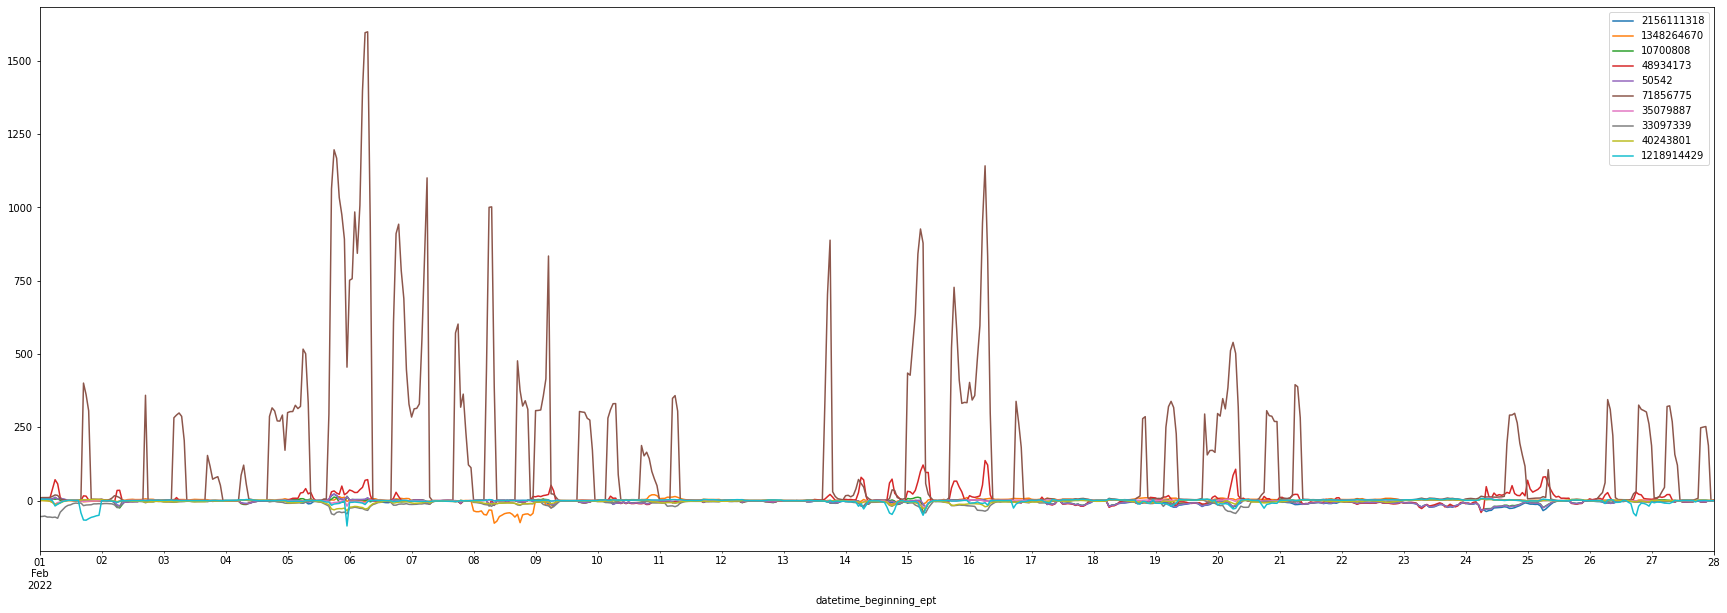

In [134]:
fig, ax = plt.subplots(1,1,figsize=(30,10))

for s in auc_results['Source PNODEID'].sample(10):
    Feb_hrl_lmps.plot(y = s, ax=ax, label = str(s))
    
ax.legend()

## Computing Vols

<AxesSubplot:>

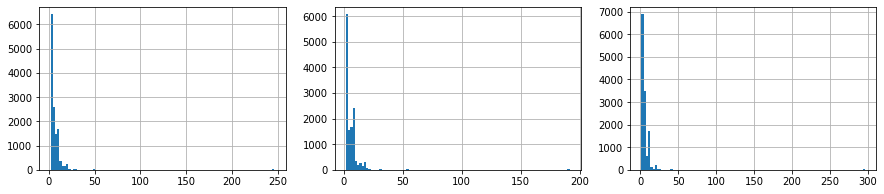

In [100]:
onpeak = ((Feb_hrl_lmps.index.weekday <= 5) &\
     (Feb_hrl_lmps.index.hour >= 7) &\
     (Feb_hrl_lmps.index.hour < 23))
offpeak = ~onpeak

fig, ax = plt.subplots(1, 3, figsize = (15,3))
Feb_hrl_lmps.std().hist(bins = 100, ax = ax[0])
Feb_hrl_lmps[onpeak].std().hist(bins = 100, ax = ax[1])
Feb_hrl_lmps[offpeak].std().hist(bins=100, ax = ax[2])

<AxesSubplot:xlabel='datetime_beginning_ept'>

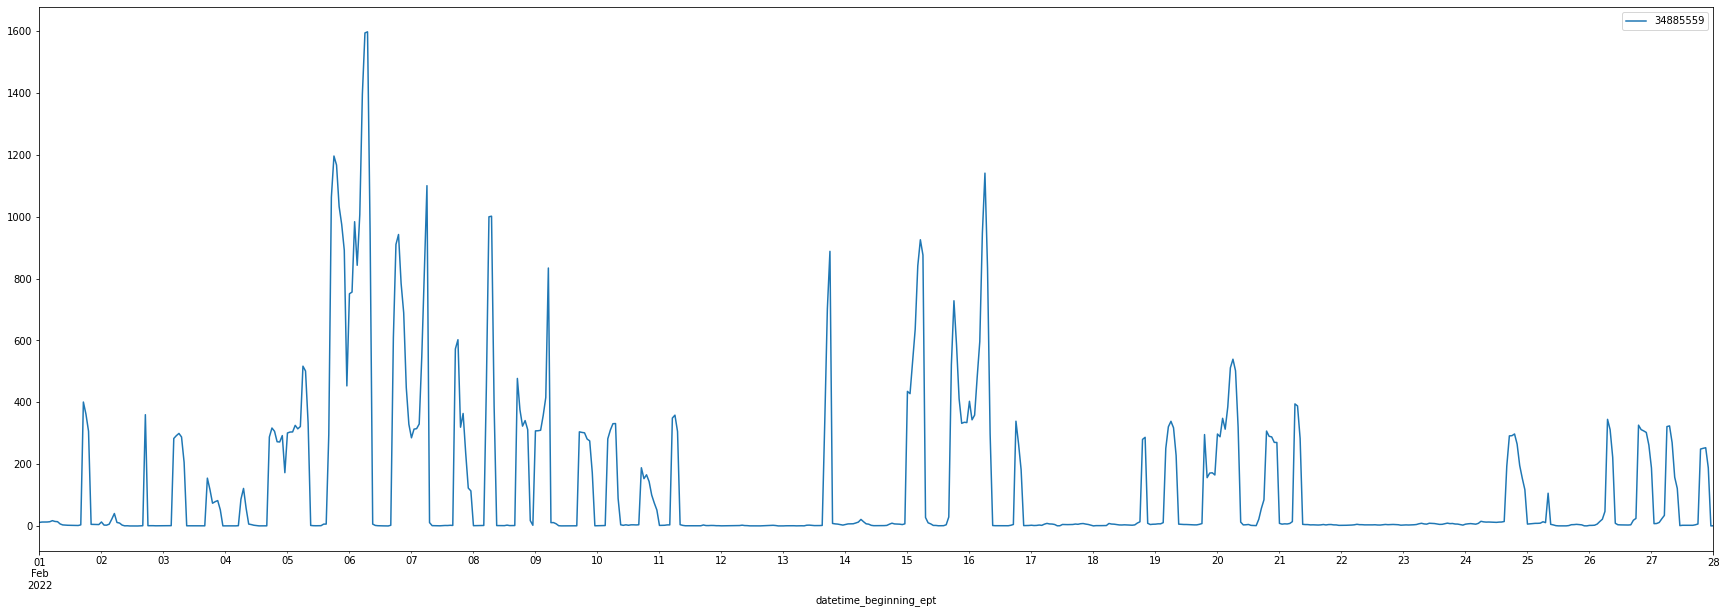

In [101]:
fig, ax = plt.subplots(1,1, figsize = (30,10))
node_id = Feb_hrl_lmps.std().idxmax()
Feb_hrl_lmps.plot(y = node_id, ax = ax)

In [102]:
def lookup_vols(df, lmps):
    
    class_type = df.index[0]
    
    if class_type == 'OnPeak':
        f = ((lmps.index.weekday <= 5) &\
            (lmps.index.hour >= 7) &\
            (lmps.index.hour < 23))
    elif class_type == 'OffPeak':
        f = ~((lmps.index.weekday <= 5) &\
            (lmps.index.hour >= 7) &\
            (lmps.index.hour < 23))
    else:
        f = lmps.index.weekday <= 7 #All days of week
        
    #vol = lmps[f].std().rename('vol')
    vol = (lmps[f].sum()**2).rename('vol')
    
    df = df.merge(vol, left_on = 'Source PNODEID', right_index = True)
    df = df.rename(columns = {'vol':'Source vol'})
    
    df = df.merge(vol, left_on = 'Sink PNODEID', right_index = True)
    df = df.rename(columns = {'vol':'Sink vol'})
    
    return df

if 'Source vol' in auc_results.columns:
    auc_results.drop(columns = ['Source vol','Sink vol'], inplace=True)

auc_results = auc_results.groupby('Class Type').apply(lookup_vols, Feb_hrl_lmps)
auc_results.reset_index(drop=True, inplace = True)

In [103]:
auc_results.sample(3)

,FTRID,Class Type,Participant,Source Node,Source PNODEID,Sink Node,Sink PNODEID,Trade Type,Cleared MW,Obligation MCP,Source clmp,Sink clmp,Payoff,Premium,Source vol,Sink vol
155779,259333812,OnPeak,BNCRFT,TRICESLK115 KV TX1,34886889,KIDDSTDP115 KV TX1,34886799,Buy,4.0,-70.74,3.010247,2.975701,-23.214545,47.525455,3.816748e+06,3.729649e+06
143930,258762456,OnPeak,DYNECA,COLU PL 69 KV DAN2LOAD,1775807796,ELDRED 69 KV GMILLSLF,51520089,Sell,0.3,-103.60,-3.630801,-4.308690,-455.541448,351.941448,5.552574e+06,7.819517e+06
14295,255263373,OffPeak,FEELLC,OREGONEN19 KV CTG12,1338431708,DOLAHARD34.5 KV HOGCREWF,1388614226,Buy,2.0,310.81,0.723267,0.861032,92.578613,-218.231387,2.203364e+05,3.122686e+05


<AxesSubplot:xlabel='Sink vol', ylabel='Premium'>

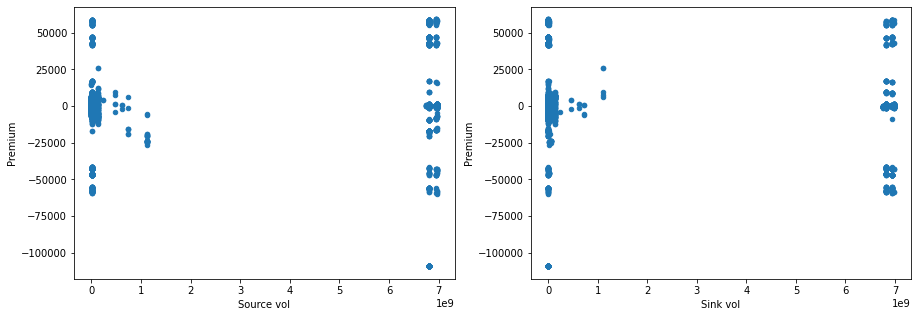

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

auc_results.plot.scatter(x = 'Source vol', y = 'Premium', ax = ax[0])
auc_results.plot.scatter(x = 'Sink vol', y = 'Premium', ax = ax[1])

In [105]:
def lookup_covar(df, lmps):    
    source = df['Source PNODEID'].iloc[0]
    sink = df['Sink PNODEID'].iloc[0]
    #return lmps[source].cov(lmps[sink])
    return lmps[source].sum()*lmps[sink].sum()
    
class_types = ['OffPeak', 'OnPeak', '24H']
split_auc = {}
lmp_filt = {}

for c in class_types:
    split_auc[c] = auc_results[auc_results['Class Type'] == c]
    if c == 'OnPeak':
        lmp_filt[c] = ((Feb_hrl_lmps.index.weekday <= 5) &\
            (Feb_hrl_lmps.index.hour >= 7) &\
            (Feb_hrl_lmps.index.hour < 23))
    elif c == 'OffPeak':
        lmp_filt[c] = ~((Feb_hrl_lmps.index.weekday <= 5) &\
            (Feb_hrl_lmps.index.hour >= 7) &\
            (Feb_hrl_lmps.index.hour < 23))
    else:
        lmp_filt[c] = Feb_hrl_lmps.index.weekday <= 7 #All days of week
        

for c in class_types:
    split_auc[c] = pd.DataFrame(split_auc[c].groupby(by=['Source PNODEID', 'Sink PNODEID']).apply(lookup_covar, Feb_hrl_lmps[lmp_filt[c]]))
    split_auc[c].rename(columns={0:'covar'}, inplace=True)
    split_auc[c]['Class Type'] = c
    split_auc[c].reset_index(inplace=True)
    
covars = pd.concat([split_auc[c] for c in class_types], ignore_index=True)

In [106]:
if 'covars' in auc_results.columns:
    auc_results.drop(columns=['covars'], inplace=True)

auc_results = auc_results.merge(covars)

In [107]:
auc_results

,FTRID,Class Type,Participant,Source Node,Source PNODEID,Sink Node,Sink PNODEID,Trade Type,Cleared MW,Obligation MCP,Source clmp,Sink clmp,Payoff,Premium,Source vol,Sink vol,covar
0,252685912,24H,ENDURE,577 S EL34.5 KV WGRF,53049057,1 LASALL24 KV LA-1,32417525,Buy,2.0,-4.33,-6.225393,-6.350894,-84.336518,-80.006518,1.632386e+07,1.698866e+07,1.665294e+07
1,257705729,24H,DECAM,FOWLER 34.5 KV FWL2-3WF,87901605,1 LASALL24 KV LA-1,32417525,Sell,2.0,7195.28,-11.699414,-6.350894,3594.205978,3601.074022,5.765243e+07,1.698866e+07,3.129597e+07
2,257705718,24H,DECAM,FOWLER 34.5 KV FWL2-3WF,87901605,20 BRAID24 KV BR-1,32417599,Sell,3.0,7192.26,-11.699414,-6.496888,3496.098120,3696.161880,5.765243e+07,1.777870e+07,3.201540e+07
3,258774927,24H,BPQF,MISO,40523629,20 BRAID24 KV BR-1,32417599,Buy,0.4,-2791.29,-2.727764,-6.496888,-2532.850835,258.439165,3.134029e+06,1.777870e+07,7.464515e+06
4,258761109,24H,BPCONN,GLNDL_EK69 KV LD_185,1123174813,20 BRAID24 KV BR-1,32417599,Buy,0.4,-7386.02,2.966302,-6.496888,-6359.263359,1026.756641,3.706126e+06,1.777870e+07,-8.117272e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162292,259334475,OnPeak,BNCRFT,WILLOWGR69 KV T1,2156108994,LAMIRASW69 KV LAMIRA,2156109006,Buy,4.0,10.16,-0.054407,-0.036934,11.741880,1.581880,1.246796e+03,5.745609e+02,6.234113e+03
162293,258222420,OnPeak,AMAZAN,WILMERDI138 KV T4,21601765,EVERGREE138 KV LOAD,21601697,Buy,1.8,-22.22,-0.346733,-0.346718,0.010354,22.230354,5.063850e+04,5.063400e+04,2.324192e+03
162294,259429317,OnPeak,BZNG15,WILMERDI138 KV T4,21601765,PINECRK 138 KV T1,41935435,Buy,0.3,-114.46,-0.346733,-0.344961,1.190755,115.650755,5.063850e+04,5.012225e+04,2.365558e+03
162295,259110937,OnPeak,ELMGN,WOLFRUN 138 KV WOLFRUN,5021613,SUTTONHI69 KV T1,1268560160,Buy,3.4,-7.78,0.407951,0.384191,-15.966471,-8.186471,7.009786e+04,6.217044e+04,6.602749e+04


In [108]:
#auc_results['FTR vol'] = (auc_results['Sink vol']**2 + auc_results['Source vol']**2 - 2*auc_results['covar'])
auc_results['FTR vol'] = (auc_results['Sink vol'] + auc_results['Source vol'] - 2*auc_results['covar'])
#auc_results['FTR vol'] = auc_results['FTR vol']**(1/2)

c:\users\bkrak\appdata\local\programs\python\python39\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='FTR vol', ylabel='Premium'>

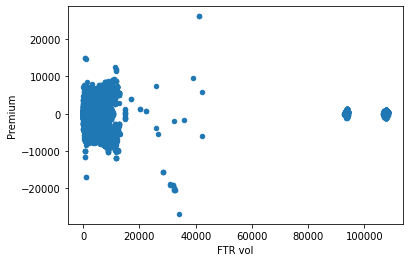

In [117]:
#maybe need to normalize by ClearedMW*Clearing price
auc_results['FTR vol'] = np.sqrt(auc_results['FTR vol'])
auc_results[~outliers].plot.scatter(x = 'FTR vol', y = 'Premium')

In [123]:
import statsmodels.api as sm

nans = auc_results['FTR vol'].isna()

model = sm.OLS(auc_results[~nans&~outliers]['Premium'],auc_results[~nans&~outliers]['FTR vol'],hasconst=True)
res = model.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Premium   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 05 Apr 2022   Prob (F-statistic):                nan
Time:                        12:22:16   Log-Likelihood:            -1.3318e+06
No. Observations:              155724   AIC:                         2.664e+06
Df Residuals:                  155723   BIC:                         2.664e+06
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FTR vol        0.0010      0.000      2.025      0.043    3.18e-05       0.002
==============================================================================
Omnibus:                    42820.668   Durbin-Watson:                   1.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2155126.007
Skew:                          -0.533   Prob(JB):                         0.00
Kurtosis:                      21.194   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

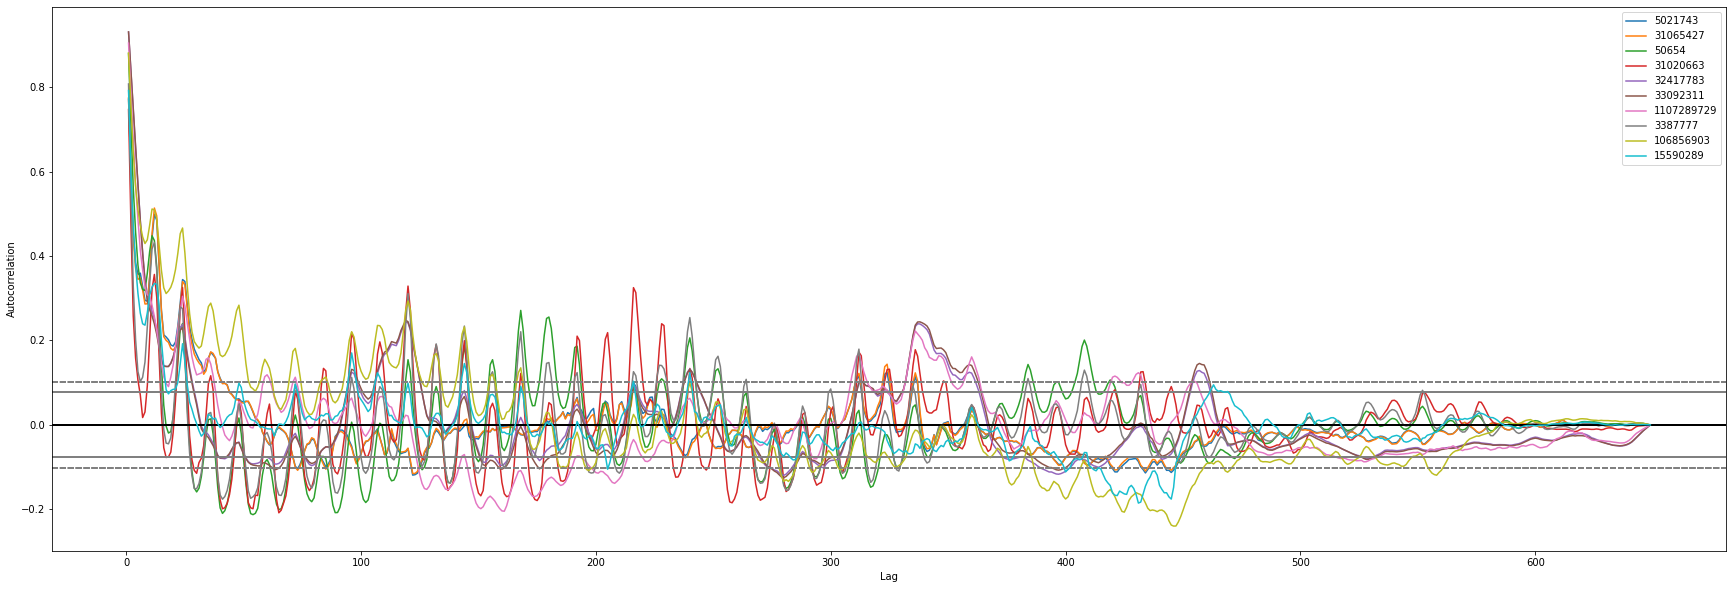

In [110]:
from pandas.plotting import autocorrelation_plot
fig, ax = plt.subplots(1,1,figsize=(30,10))

for s in auc_results['Source PNODEID'].sample(10):
    autocorrelation_plot(Feb_hrl_lmps[s], ax=ax, label = str(s))
    
ax.legend()

In [111]:
#Trying to figure out what average autocorrelation structure is

def auto_corr(series,lags = 100):
    return pd.Series([series.autocorr(lag=lag) for lag in range(lags)])

auto_corr = Feb_hrl_lmps.apply(auto_corr)

KeyboardInterrupt: 

In [ ]:
plt.scatter(x=range(auto_corr.shape[0]),y=auto_corr.abs().mean(axis=1))

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(30,10))

for c in auto_corr.columns:
    auto_corr[c].plot(ax=ax, style = '.')

In [ ]:
auto_corr[c].plot()

In [ ]:
auto_corr[auto_corr.min(axis=1) > .05]

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
import scipy.fft
fig, ax = plt.subplots(1,1,figsize=(30,10))

Feb_hrl_lmps.index.freq = 'H'

def normalize(x):
    return x/x.max()

for s in auc_results['Source PNODEID'].sample(1):
    ax.plot(Feb_hrl_lmps.index, Feb_hrl_lmps[s], label = 'Signal')
    ax.plot(Feb_avg_lmps.index, Feb_avg_lmps[s], label = 'Seasonal Avg')
    
    #Examining FFT
    #spectra = scipy.fft.fft(Feb_hrl_lmps[s].values)    
    #ax.plot(Feb_hrl_lmps.index[:24*7], normalize(np.abs(spectra)**2), label = 'spectra')
    
    #ax.plot(Feb_hrl_lmps.index, scipy.fft.ifft(spectra), label = 'Seasonal signal')
    
    #AR Model
    #model = AutoReg(Feb_hrl_lmps[s].values[:2*24*7], seasonal = True, period  = 24*7, lags = 2)
    #model_fit = model.fit()
    #ax.plot(Feb_hrl_lmps.index, model.predict(params=model_fit.params,start=1,end=Feb_hrl_lmps.shape[0]), label = str(s))
    
ax.legend()

In [ ]:
Feb_hrl_lmps['weekhour'] = Feb_hrl_lmps.index.weekday*4+np.floor(Feb_hrl_lmps.index.hour/4)
Feb_avg_lmps = Feb_hrl_lmps.groupby('weekhour').transform(lambda x: x.mean())

In [ ]:
Feb_avg_lmps.plot(y=1)

In [ ]:
# covariances = Feb_hrl_lmps.pivot(index = 'datetime_beginning_ept', columns = 'pnode_id', values = 'congestion_price_da').cov()
# covariances.reset_index(inplace=True)
# covariances = covariances.melt(id_vars = ['pnode_id'], var_name = 'Source PNODEID', value_name = 'covar')
# covariances.rename(columns={'pnode_id': 'Sink PNODEID'}, inplace=True)

In [ ]:
payoff = auc_results[~outliers].groupby('Participant').apply(lambda x : (x['Cleared MW']*x['Payoff']).sum())
premia = auc_results[~outliers].groupby('Participant').apply(lambda x : (x['Cleared MW']*x['Premium']).sum())
payment = auc_results[~outliers].groupby('Participant').apply(lambda x : (x['Cleared MW']*x['Obligation MCP']*bool_to_pm1(x['Trade Type'] == 'Buy')).sum())
PnL = pd.DataFrame(index = premia.index, columns = ['Premia', 'Payment'])
PnL['Premia'] = premia
PnL['Payment'] = payment
PnL['Payoff'] = payoff

In [ ]:
fix, ax = plt.subplots(1,1)
PnL.plot.scatter('Payment', 'Payoff', ax = ax)
plot_xy(ax)

In [ ]:
PnL.sort_values(by = ['Payoff'], ascending = False)[0:10]